# Prediction

- **Mouse ID**: m03_d4
- **Predicting**: Neural data (original dimensionality)
- **Predictor**: VGG19 layerwise features (reduced to various numbers of PCs)
- **Plotting**: VGG19 layerwise mean FEV vs. number of feats PCs used (line)
- **Plotting**: VGG19 mean FEV for each layer with best performing number of PCs (bar)

In [ ]:
from cortexlib.utils import file as futils
from cortexlib.mouse import CortexlabMouse
from cortexlib.images import CortexlabImages
from cortexlib.vgg19 import PreTrainedVGG19Model, PoolingMode
from cortexlib.predictor import NeuralResponsePredictor
from cortexlib.utils.plotting import vgg19_colours
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.logging import Logger
import matplotlib.pyplot as plt
import pandas as pd

logger = Logger()
set_global_seed()

In [ ]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

In [ ]:
mouse = CortexlabMouse(mouse_id=MOUSE_ID)

logger.progress(f"Computing null distributions for all neurons in mouse {mouse.id}")
null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
logger.success(f"Null distributions computed")

real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
reliable_neuron_indices = mouse.get_reliable_neuron_indices(
            null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

logger.info(f"Neural responses shape: {neural_responses.shape}")

17:32:13 | INFO     | ⏳ Computing null distributions for all neurons in mouse m03_d4...
17:32:38 | SUCCESS  | ✅ Null distributions computed!
17:32:38 | INFO     | ℹ️ Neural responses shape: (1573, 2, 500)


In [ ]:
futils.save_filtered_neural_data(
    mouse_id=mouse.id,
    neural_responses=neural_responses,
    neural_responses_mean=neural_responses_mean)

17:32:38 | INFO     | ℹ️ Skipping save, file already exists at /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_1/_neural_data/neural_data_mouse_m03_d4.pt


In [4]:
vgg19 = PreTrainedVGG19Model(pooling_mode=PoolingMode.AVGPOOL)

settings = vgg19.get_image_settings()
images = CortexlabImages(
    size=settings['size'],
    channels=settings['channels'],
    normalise_mean=settings['mean'], 
    normalise_std=settings['std'],
    rescale_per_image=settings['rescale_per_image'],
)

logger.progress("Loading and preprocessing images shown to mouse")
image_dataset = images.load_images_shown_to_mouse(mouse.image_ids)
logger.success("Images processed")

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
17:32:39 | INFO     | ⏳ Loading and preprocessing images shown to mouse...
17:32:53 | SUCCESS  | ✅ Images processed!


In [5]:
logger.progress("VGG19: extracting features from images shown to mouse")
vgg19_feats, labels = vgg19.extract_features_with_pooling(image_dataset)
logger.success("VGG19 features extracted")

for layer, feats in vgg19_feats.items():
    logger.info(f"{layer} feats shape: {tuple(feats.shape)}")

17:32:53 | INFO     | ⏳ VGG19: extracting features from images shown to mouse...


  0%|          | 0/99 [00:00<?, ?it/s]

17:36:32 | SUCCESS  | ✅ VGG19 features extracted!
17:36:32 | INFO     | ℹ️ conv2_2 feats shape: (1573, 128)
17:36:32 | INFO     | ℹ️ conv3_4 feats shape: (1573, 256)
17:36:32 | INFO     | ℹ️ conv4_4 feats shape: (1573, 512)
17:36:32 | INFO     | ℹ️ conv5_4 feats shape: (1573, 512)
17:36:32 | INFO     | ℹ️ fc2 feats shape: (1573, 4096)


In [ ]:
futils.save_model_features(model=futils.Model.VGG19, mouse_id=mouse.id, features=vgg19_feats, labels=labels)

17:36:32 | INFO     | ℹ️ Saving model features to /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_1/_model_features/vgg19_features_mouse_m03_d4.pt
17:36:32 | SUCCESS  | ✅ Model features saved!


In [7]:
# Compute test-train split indexes just once - and apply both to all layers
logger.progress("Computing test/train split for regression: VGG19 Feats => Neural Data")

num_images = vgg19_feats['conv2_2'].shape[0]
split = NeuralResponsePredictor.get_train_test_indexes(num_images)
logger.success(f"Computed train/test split")

17:36:32 | INFO     | ⏳ Computing test/train split for regression: VGG19 Feats => Neural Data...
17:36:32 | SUCCESS  | ✅ Computed train/test split!


In [8]:
fev_results = []

logger.progress("Running regressions: VGG19 Feats => Neural Data")
for layer, feats in vgg19_feats.items():
    logger.progress(f"VGG19 {layer}")

    for n_pcs in [None, 10, 20, 50, 100]:
        predictor = NeuralResponsePredictor(
            reduce_image_representation_to_n_pcs=n_pcs,
            train_idx=split['train_idx'],
            test_idx=split['test_idx'],
        )
        fev = predictor.compute_fev(feats, neural_responses)

        fev_results.append({
            'layer': layer,
            'n_pcs': n_pcs,
            'test_r2': fev['test_r2'],
            'mean_fev': fev['mean_fev']
        })

logger.success(f"Regressions complete")

17:36:32 | INFO     | ⏳ Running regressions: VGG19 Feats => Neural Data...
17:36:32 | INFO     | ⏳ VGG19 conv2_2...
17:36:36 | INFO     | ⏳ VGG19 conv3_4...
17:36:39 | INFO     | ⏳ VGG19 conv4_4...
17:36:44 | INFO     | ⏳ VGG19 conv5_4...
17:36:49 | INFO     | ⏳ VGG19 fc2...
17:37:03 | SUCCESS  | ✅ Regressions complete!


In [ ]:
futils.write_json_file(fev_results, f'./prediction.json')

In [10]:
fev_results_df = pd.DataFrame(fev_results)
fev_results_df.head(12)

,layer,n_pcs,test_r2,mean_fev
0,conv2_2,NaN,0.012968,0.088767
1,conv2_2,10.0,0.011976,0.085650
2,conv2_2,20.0,0.012794,0.088273
3,conv2_2,50.0,0.012962,0.088752
4,conv2_2,100.0,0.012968,0.088767
5,conv3_4,NaN,0.012050,0.082975
6,conv3_4,10.0,0.011455,0.081542
7,conv3_4,20.0,0.011825,0.082493
8,conv3_4,50.0,0.012013,0.082965
9,conv3_4,100.0,0.012047,0.082980


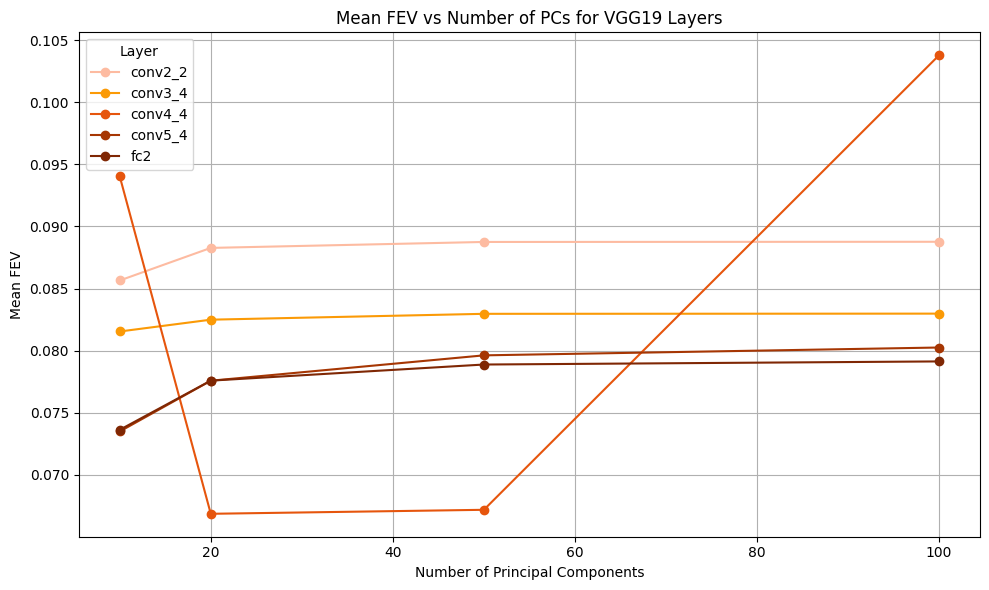

In [11]:
plt.figure(figsize=(10, 6))

for layer in fev_results_df['layer'].unique():
    layer_results = fev_results_df[fev_results_df['layer'] == layer]
    plt.plot(layer_results['n_pcs'], layer_results['mean_fev'], marker='o', color=vgg19_colours[layer], label=layer)

plt.xlabel('Number of Principal Components')
plt.ylabel('Mean FEV')
plt.title('Mean FEV vs Number of PCs for VGG19 Layers')
plt.legend(title='Layer')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
best_fev_per_layer = fev_results_df.loc[fev_results_df.groupby("layer")["mean_fev"].idxmax()]
best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
0,conv2_2,NaN,0.012968,0.088767
9,conv3_4,100.0,0.012047,0.082980
10,conv4_4,NaN,0.011352,0.104368
15,conv5_4,NaN,0.008218,0.080550
20,fc2,NaN,0.006127,0.079454


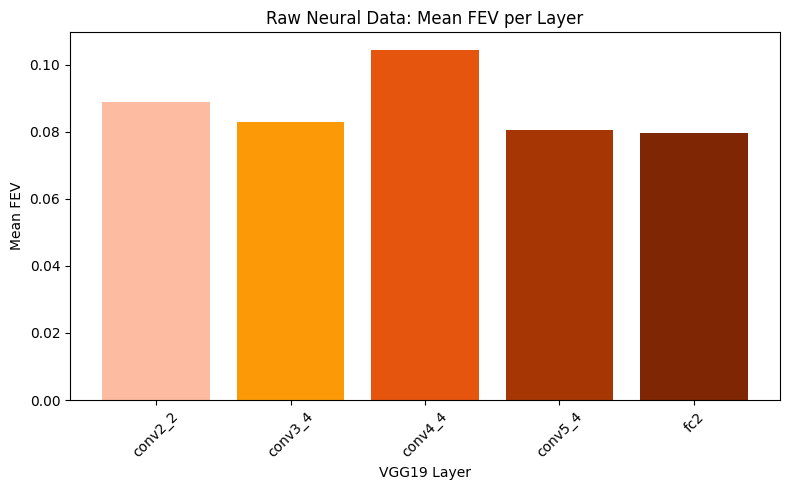

In [13]:
layers = [row["layer"] for _, row in best_fev_per_layer.iterrows()]
mean_fevs = [row["mean_fev"] for _, row in best_fev_per_layer.iterrows()]

colors = [vgg19_colours[layer] for layer in layers]

plt.figure(figsize=(8, 5))
plt.bar(layers, mean_fevs, color=colors)
plt.ylabel("Mean FEV")
plt.xlabel("VGG19 Layer")
plt.title("Raw Neural Data: Mean FEV per Layer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()